# Preprocessing data in MNE-Python

`
Authors:
Britta Westner, Alexandre Gramfort, Denis A. Engemann, Anne Cheylus
`

## Setup

We start out with loading the packages we need. These include `matplotlib` for plotting, `os` for path management, `numpy` for numerical computations, and of course `mne` and `mne_bids`.
We can also use matplotlib magic to ask for figure to be plotted inline. 

In [ ]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
import mne_bids
import pandas

Let's double check your MNE-Python version. This should give back 1.5.0 or more

In [ ]:
mne.__version__

We set the log-level of MNE-Python to 'warning' so the output is less verbose:

In [ ]:
mne.set_log_level('warning')

### Help!

Remember, if you need help just ask ... the machine!
Let's see how to get the docstring information for a function - here, the function `set_log_level`.

In [ ]:
mne.set_log_level?

## Get the path to the data with mne_bids

You should have downloaded the `WorkingMemory bids_data` folder with the download notebook: [0a-Download_data.ipynb](0a-Download_data.ipynb). 

We have to let Python know where to find this folder on your disk. 

You will have to adjust the `bids_root` path below to reflect your computer and path structure!
You can print the whole path and check the directory to double check it's correct.

In [ ]:
bids_root = './bids_data'

In [ ]:
bids_path = mne_bids.BIDSPath(root=bids_root, 
                              task='WorkingMemory',
                              subject='02',
                              session='01', 
                              run=1, 
                              datatype='meg')
print(bids_path)

This path is just a construction based on BIDS standards. To check if the file really exists, you can invoke:

In [ ]:
bids_path.fpath.exists()

## Access and read the raw data

We can read raw data with `mne_bids.read_raw_bids` or directly with `mne.io.read_raw_ctf`. 

With mne_bids, you also load sidecar TSV files with information on events and channels.

In [ ]:
mne_bids.read_raw_bids?

In [ ]:
raw = mne_bids.read_raw_bids(bids_path=bids_path, 
                             verbose='info', 
                             extra_params=dict(preload=False,
                                               system_clock='ignore'))

We can see that `mne_bids` changed the units for miscelaneous channels, eyetrack data and system clock from V to NA, and changed all their types to `misc`
For general info on importing data you can check:
- for MEG: https://mne.tools/stable/auto_tutorials/io/plot_10_reading_meg_data.html
- for EEG: https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html
- whith BIDS: https://mne.tools/mne-bids/stable/auto_examples/read_bids_datasets.html

## Understand your data file


Now let's look at the measurement info. It can give details about:

   - sampling rate
   - filtering parameters
   - available channel types
   - bad channels
   - etc.

In [ ]:
print(raw.info)

<div class="alert alert-success">
    <b>Exercise</b>:
     <ul>
    <li>How many channels do you have for each type of sensors?</li>
    <li>What is the sampling frequency?</li>
    <li>Has the data been filtered?</li>
    <li>What is the frequency of the line noise?</li>
    <li>Is there any bad channel?</li>
    </ul>
</div>

## A closer look at the info dictionary

raw.info is just a dictionary:

In [ ]:
isinstance(raw.info, dict)

In [ ]:
raw.info.keys()

So we can access its elements using square brackets and keys:

In [ ]:
raw.info['sfreq']  # Sampling frequency

In [ ]:
raw.info['line_freq'] # Power noise

In [ ]:
raw.info['bads'] # Bad channels

## A closer look at the channels
Next let's see what channels are present. It is available via the `raw.ch_names` attribute.

In [ ]:
type(raw.ch_names)

In [ ]:
raw.ch_names[:10]  # this prints the first ten channels

You can index it as a list

In [ ]:
raw.ch_names[42]

We can also query the channel type of a specific channel:

In [ ]:
channel_type = mne.io.pick.channel_type(raw.info, 0)
print('Channel #0 (', raw.ch_names[0],') is of type:', channel_type)  # print this out in a neat way

channel_type = mne.io.pick.channel_type(raw.info, 1)
print('Channel #1 (', raw.ch_names[1],') is of type:', channel_type)  

channel_type = mne.io.pick.channel_type(raw.info, 2)
print('Channel #2 (', raw.ch_names[2],') is of type:', channel_type)  

channel_type = mne.io.pick.channel_type(raw.info, 30)
print('Channel #30 (', raw.ch_names[30],') is of type:', channel_type)

The info also contains all the details about the sensors (type, locations, coordinate frame etc.) in `chs`:

In [ ]:
len(raw.info['chs'])

In [ ]:
type(raw.info['chs'])

In [ ]:
raw.info['chs'][0]  # check the first channel

In [ ]:
raw.info['chs'][30]

Now that we know that there are MEG channels in the data, we can plot their position:

In [ ]:
# Increase figure size to give some place for our 272 MEG channels
plt.figure(figsize=(15,15))
raw.plot_sensors(kind='topomap', ch_type='mag', show_names=True, axes=plt.gca());

## Accessing the data

To access the data just use the `[]` syntax as to access any element of a list, dict etc. Note that `raw[]` returns two things: the data and the times array.

In [ ]:
start, stop = 0, 50000
data, times = raw['USPT001', start:stop]  # fetch first 50000 points in stimulus channel
print(data.shape)
print(times.shape)

In [ ]:
times[:10]  # always starts at 0 by convention

In [ ]:
data[0,:10] # data shape matches channels x time

## Look at the event structure of the data

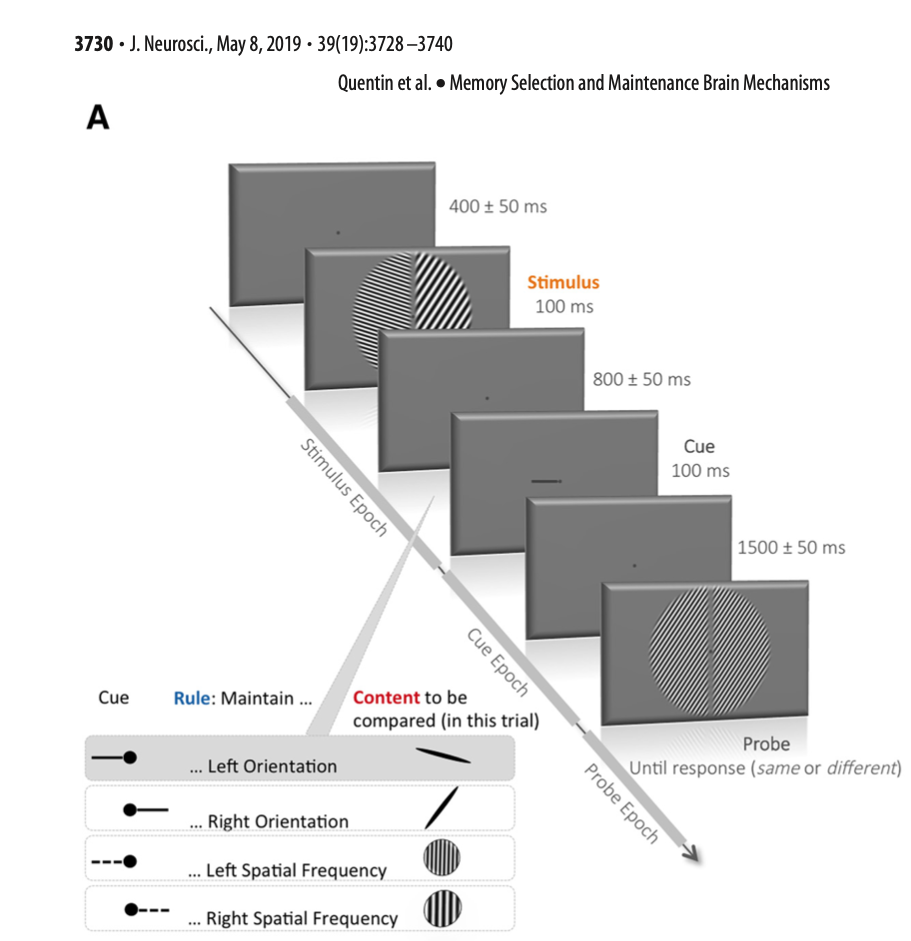


Triggers are delivered at the time of

- Stimulus Presentation with a code for the stimulus ranging from 1 to 125
- Cue Presention :
    - Left Spatial Frequency with code 126
    - Left Oriention with code 127
    - Right Spatial Frequency with code 128
    - Right Oriention with code 129
- Probe Presentation with codes ranging from 130 to 155


In [ ]:
pandas.DataFrame(raw.annotations[:10])

In [ ]:
stim_id = dict([ ('stimulus' + str(i), i) for i in range(1,126)] )
cue_id = {'CueLeftSF': 126,
          'CueLeftOrient/': 127,
          'CueRightSF': 128,
          'CueRightOrient': 129}
probe_id = dict([ ('Probe' + str(i-129), i) for i in range(130,156) ])
# merge all 3 in event_id
event_id = stim_id.copy()
event_id.update(cue_id)
event_id.update(probe_id)

In [ ]:
events, evtid = mne.events_from_annotations(raw, event_id)
print(events[:10])

<div class="alert alert-success">
    <b>Exercise</b>:
    <ul>
    <li>What is the type of the variable events?</li>
    <li>What is the meaning of the 3 columns of events?</li>
    <li>How many events of the value 126 are there?
    </ul>
</div> 

### Exercice solution

In [ ]:
type(events)

see MNE documentation on events here: https://mne.tools/dev/glossary.html#term-events

In [ ]:
np.count_nonzero(events[:,2] == 126)

### Correct for constant delay

Measurements with a photodiod revealed a constant delay of 48 ms between trigger and actual stimulus presentation. 

We need to correct the events accordingly.

In [ ]:
delay = int(round(0.048 * raw.info['sfreq']))
events[:, 0] = events[:, 0] + delay

Let's visualize the paradigm:

In [ ]:
cue_events = events[[i in [126, 127, 128, 129] for i in events[:, 2]]]  # take only cue events with code between 126 and 128

In [ ]:
fig = mne.viz.plot_events(cue_events, raw.info['sfreq'], event_id=event_id, on_missing='ignore');

## Plotting raw data

Let's quickly look at our raw data! 

For full functionality, we ask matplotlib to show the plot in a separate window.

We also plot our shifted events, you can see the 48 ms delay measured with the photodiode between 

- original annotations based on BIDS _events.tsv files and 
- our newly computed events.

For more information on visualizing of raw data, see here: 
https://mne.tools/stable/auto_tutorials/raw/40_visualize_raw.html


In [ ]:
raw.info['bads']

In [ ]:
%matplotlib qt
raw.plot(event_id=event_id, events=events)

## Filtering the data 

We want to low-pass filter the data under 25 Hz using a linear-phase finite-impulse response (FIR) filter.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Which parameters do we have to set to achieve this, based on the docstring of the `filter` method?</li>
    </ul>
</div>


In [ ]:
raw.filter?

In [ ]:
raw.load_data()
raw.filter(l_freq = None, h_freq=25.0, fir_design='firwin', verbose='INFO')

Now that we filtered our data, let's look at it again. Can you spot the difference?

In [ ]:
%matplotlib qt
raw.plot(event_id=event_id, events=events)

## Handling bad channels

Visual inspection of the raw data with `raw.plot` reveals an atypical signal for channel `MLT16` compared to its neighbors:

In [ ]:
picks = mne.pick_channels(raw.ch_names, ['MLT15', 'MLP56', 
                                         'MLT26', 'MLT16', 'MLP55', 
                                         'MLT27', 'MLO14', 'MLP54'], 
                          ordered = True)
raw.plot(order=picks, n_channels=len(picks))

We can mark this channel as bad either interactively on `raw.plot()` or programmatically as below. This will make it easier to exlude it from further analyses. It now appears grayed on `raw.plot()`.

In [ ]:
raw.info["bads"].append("MLT16")  # add a single channel
raw.plot(order=picks, n_channels=len(picks))

For more information on handling bad channels, see https://mne.tools/stable/auto_tutorials/preprocessing/15_handling_bad_channels.html

## Epoch data

We will focus on the timing around the initial stimulus presentation, before the subject sees the cue and the probe.

Define epochs parameters:

In [ ]:
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.9  # end of each epoch (900ms after the trigger)

Define the baseline period:

In [ ]:
baseline = (-0.2, 0)  # means from 200ms before to stim onset (t = 0)

We also pick MEG channels now - we don't need the trigger channel anymore.

In [ ]:
picks = mne.pick_types(raw.info, meg=True, ref_meg = False,
                       stim=False, exclude='bads')

Now we can put all of this together and create stimulus epochs. We will use the `decim` parameter to downsample our signal. See the warning on https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.decimate

Our signal was at 1200 Hz so decimating by 10 should lead to a new sampling frequency of 120 Hz. To avoid aliasing effects, we need to make sure there is no significant power above half this frequency (60 Hz) wich is OK since we used a lowpass at 25 Hz.

In [ ]:
epochs = mne.Epochs(raw, events, stim_id, tmin, tmax, proj=True, 
                    picks=picks, baseline=baseline, decim = 10,
                    detrend = 1,
                    on_missing='ignore', verbose='Error')

In [ ]:
print(epochs)  # let's look at some details about the epochs object

In [ ]:
epochs.load_data();  # load data in memory

## Visualizing epochs data

See [this page](https://mne.tools/stable/auto_tutorials/epochs/20_visualize_epochs.html) for options on how to visualize epochs.

We can also look at the epochs in a data browser window:

In [ ]:
%matplotlib qt
epochs.plot(events=True);

## Merge epochs from several runs

We can do a loop to do the same processing steps on all runs and merge epochs in a single file for further processing

In [ ]:
# specify a C locale to enable date reading on Linux
import locale
locale.setlocale(locale.LC_ALL, 'C')

In [ ]:
mne_bids.get_entity_vals(bids_root, 'run')

In [ ]:
epochs_list = list()
for run in mne_bids.get_entity_vals(bids_root, 'run'):
    # update our bids PATH whith this run number
    bids_path = bids_path.update(run=run)
    print(bids_path)
    raw = mne_bids.read_raw_bids(bids_path=bids_path, 
                                 verbose='error', 
                                 extra_params=dict(preload=False,
                                                   system_clock='ignore'))
    # correct our stimulus channel
    raw.load_data()  # load data into memory
    # find triggers
    events_meg, evtid = mne.events_from_annotations(raw, event_id)
    # Add 48ms to the trigger events (according to delay with photodiod)
    events_meg[:, 0] += int(round(.048 * raw.info['sfreq']))
    # filter the raw
    raw.filter(l_freq=None, h_freq=25.0, fir_design='firwin')
    # Epoch the data
    tmin = -0.2
    tmax = 0.9
    epochs = mne.Epochs(raw, events_meg, event_id=stim_id,
                        tmin=tmin, tmax=tmax, preload=True,
                        baseline=(-0.2, 0), decim=10, 
                        detrend = 1,
                        on_missing='ignore', verbose=False)
    # Copy first run dev_head_t to following runs
    if run == '01':
       dev_head_t = epochs.info['dev_head_t']
    else:
       epochs.info['dev_head_t'] = dev_head_t
    epochs_list.append(epochs)
epochs = mne.epochs.concatenate_epochs(epochs_list)

## Save Epochs

We will save our epoched data in BIDS `derivatives` folder MNE-python likes epoched files to end with `-epo.fif` while mne_bids believes it is not conforming to BIDS standard, so we'll skip testing for conformance with `check = False`.

In [ ]:
epochs_path = bids_path.copy().update(root = bids_path.root / 'derivatives' / 'stimulus_epoch_preprocessing',
                                      run = None,
                                      suffix = 'meg-epo',
                                      check = False,
                                      extension = ".fif")
# Create folder if necessary
epochs_path.mkdir(exist_ok=True)
# save epochs
epochs.save(str(epochs_path), overwrite=True)
print('Wrote',epochs_path)

In [ ]:
epochs.plot(events=True, event_color=dict([(i, 'black') for i in range(1,128)]))

In [ ]:
epochs.average().plot(spatial_colors=True, gfp=True)